# Event-driven machine learning for PdM focusing on log preprocessing

An advanced data-driven predictive maintenance approach is presented in [10].
The objective of this research work is to develop an alerting system that provides
early notications to aviation engineers for upcoming aircraft failures, providing
the needed time for the maintenance actions. The aviation is a well-documented
field, as all the maintenance and 
flight data are systematically logged. Hence,
**event-based techniques** can leverage this special characteristic and **provide effective predictive solutions**. The **main challenge** is to **cope** with the large set of **og
entries** that are essentially irrelevant **to the main failures**.
In [10], the emphasis is placed on **log preprocessing**; therefore, we will refer
to this methodology as **LPPdM**.

10.Korvesis, P., Besseau, S., Vazirgiannis, M.: Predictive maintenance in aviation:
Failure prediction from post 
ight reports. In: IEEE Int. Conf. on Data Engineering
(ICDE). pp. 1414{1422 (2018)

### Setup

In [1]:
#Make the necessary imports.

suppressMessages(library(CORElearn))
suppressMessages(library(dplyr))
suppressMessages(library(plyr))
suppressMessages(library(data.table))
suppressMessages(library(randomForest))
suppressMessages(library(ggplot2))
suppressMessages(library(grid))
suppressMessages(library(argparser))
suppressMessages(library(stringr))

Warning message:
"package 'CORElearn' was built under R version 3.6.2"Warning message:
"package 'dplyr' was built under R version 3.6.2"Warning message:
"package 'plyr' was built under R version 3.6.2"Warning message:
"package 'data.table' was built under R version 3.6.2"Warning message:
"package 'randomForest' was built under R version 3.6.2"Warning message:
"package 'ggplot2' was built under R version 3.6.2"Warning message:
"package 'argparser' was built under R version 3.6.2"Warning message:
"package 'stringr' was built under R version 3.6.2"

### Init variables

In [2]:
# Make an argument parser named p and keep there the necessary variables.

p <- arg_parser("Implementation of the AIRBUS Predictor")

# Add a positional argument
p <- add_argument(p, "id", help="experiment ID")
p <- add_argument(p, "train", help="training dataset")
p <- add_argument(p, "test", help="test dataset")
p <- add_argument(p, "fet", help="different types of the fault events",default=11)
p <- add_argument(p, "tet", help="type of the target fault events",default=11)
p <- add_argument(p, "--rre", help="remove rare events", default=TRUE)
p <- add_argument(p, "--rfe", help="remove frequent events", default=TRUE)
p <- add_argument(p, "--kofe", help="keep only first event", default=TRUE)
p <- add_argument(p, "--milt", help="MIL as written in the text of the paper", default=TRUE)
p <- add_argument(p, "--mili", help="MIL as shonw in the Figure of the paper", default=FALSE)
p <- add_argument(p, "--milthres", help="MIL threshold to the sigmoid function for over-sampling", default=0.4)
p <- add_argument(p, "--steepness", help="steepness of the sigmoid function", default=0.7)
p <- add_argument(p, "--midpoint", help="midpoint of the sigmoid function (in days)", default=11)
p <- add_argument(p, "--fs", help="apply feature selection", default=FALSE)
p <- add_argument(p, "--top", help="# of features to keep in feature selection", default=3)#we have max 10 feautures(before was 200)
p <- add_argument(p, "--rer", help="rare events ratio of the target event frequency", default=0.5)
p <- add_argument(p, "--fer", help="frequent events ratio of the frequency of the most frequent event", default=0.8)
p <- add_argument(p, "--milw", help="MIL window size (in days)", default=6)
p <- add_argument(p, "--pthres", help="prediction threshold to the Risk value for a true positive episode", default=0.5)
p <- add_argument(p, "--seed", help="seed for RF", default=400)
p <- add_argument(p, "--csv", help="output for csv", default=TRUE)


p <- add_argument(p, "--spme", help="export datasets for sequential pattern minning", default=FALSE)

setwd("C:/Program Files (x86)")
p <- add_argument(p, "--java", help="the java path", default="./Java/jdk1.8.0_192/bin/java.exe")

setwd("C:/Users/PETROS PETSINIS")
p <- add_argument(p, "--python", help="the python path", default="./Anaconda/python.exe")

setwd("C:")
p <- add_argument(p, "--cep", help="complex event processing path", default="C:/Users/Public/ptyxiakh/my_spmrules.py")
p <- add_argument(p, "--spmf", help="the spmf path", default="C:/Users/Public/ptyxiakh/spmf.jar")


p <- add_argument(p, "--conf", help="minimum support (minsup)", default="70%")
p <- add_argument(p, "--minti", help="minimum time interval allowed between two succesive itemsets of a sequential pattern", default=4)
p <- add_argument(p, "--maxti", help="maximum time interval allowed between two succesive itemsets of a sequential pattern", default=5)
p <- add_argument(p, "--minwi", help="minimum time interval allowed between the first itemset and the last itemset of a sequential pattern", default=4)
p <- add_argument(p, "--maxwi", help="maximum time interval allowed between the first itemset and the last itemset of a sequential pattern", default=5)
p <- add_argument(p, "--minwint", help="min # of days before failure to expect a warning for true positive decision", default=2)
p <- add_argument(p, "--maxwint", help="max # of days before failure to expect a warning for true positive decision", default=5)

### Define the necessary variables

In [3]:
# Define the necessary variables.

argv = data.frame() #make a data frame named argv
#if( length(commandArgs(trailingOnly = TRUE)) != 0){
if(FALSE){
  argv <- parse_args(p)
} else {
  argv <- parse_args(p,c(1,"C:/Users/Public/ptyxiakh/training_my_dataset2.csv","C:/Users/Public/ptyxiakh/testing_my_dataset2.csv",11,11))
}


#init the variables
id = argv$id

train_path=argv$train
test_path=argv$test

b_length = argv$fet
target_event = argv$tet

target_event_frequency_proportion_rare = argv$rer
max_event_frequency_proportion_frequent = argv$fer

top_features = argv$top

milw = argv$milw
F_thres = argv$milthres

s = argv$steepness
midpoint = argv$midpoint
acceptance_threshold = argv$pthres

export_spm = argv$spme

max_warning_interval = argv$maxwint
min_warning_interval = argv$minwint

csv = argv$csv

seed = argv$seed

print("The data frame argv is:")
print(argv)

[1] "The data frame argv is:"
[[1]]
[1] FALSE

$help
[1] FALSE

$opts
[1] NA

$rre
[1] TRUE

$rfe
[1] TRUE

$kofe
[1] TRUE

$milt
[1] TRUE

$mili
[1] FALSE

$milthres
[1] 0.4

$steepness
[1] 0.7

$midpoint
[1] 11

$fs
[1] FALSE

$top
[1] 3

$rer
[1] 0.5

$fer
[1] 0.8

$milw
[1] 6

$pthres
[1] 0.5

$seed
[1] 400

$csv
[1] TRUE

$spme
[1] FALSE

$java
[1] "./Java/jdk1.8.0_192/bin/java.exe"

$python
[1] "./Anaconda/python.exe"

$cep
[1] "C:/Users/Public/ptyxiakh/spm_rules.py"

$spmf
[1] "C:/Users/Public/ptyxiakh/spmf.jar"

$conf
[1] "20%"

$minti
[1] 2

$maxti
[1] 4

$minwi
[1] 2

$maxwi
[1] 4

$minwint
[1] 2

$maxwint
[1] 5

$id
[1] "1"

$train
[1] "C:/Users/Public/ptyxiakh/training_my_dataset.csv"

$test
[1] "C:/Users/Public/ptyxiakh/testing_my_dataset.csv"

$fet
[1] 11

$tet
[1] 11



### Reading function
**function: read_dataset**

In [4]:
# Function for reading the csv file and save it to a two column table.

read_dataset <- function(path){
  dataset = read.table(path, header = TRUE, sep = ",", dec = ".", comment.char = "#")
  dataset[, 2]  <- as.numeric(dataset[, 2])
  return(dataset)
}

### Read train and test set

The recorded log types read from csv files.
One csv file(at **train_path**) has the **training_set** and the other(at **test_path**) the **testing_set**.

In [5]:
# Reading train and test set.

training_set = read_dataset(train_path)
test_set =  read_dataset(test_path)

print("The test_set and training_set looks like:")
print(head(test_set))

## Funtions for preprocessing

In order to increase the effectiveness of the approach standard **preprocessing** techniques are applied: 

- **Rare events (more rare than the target event)**, are considered as extremely rare, hence they are removed to reduce the dimensionality of the data. 

- **Most frequent events** usually do not contain significant information since they correspond to issues of minor importance. A tf-idf (term-frequency - inverted document frequency) or a simple threshold-based approach can be used to remove most frequent events. 

- **Multiple occurrences** of the same event in the same segment can either be noise or may not provide useful information. Hence, multiple occurrences are shrank into a single one. 

- Events of minor importance occur and appear in every segment until their underlying cause is treated by the technical experts. Hence, the **first occurrence of events** that occur in consecutive segments is maintained. 

- To deal with the imbalance of the labels (given that the target event is rare) and as several events appear shortly before the occurrence of the target event, but only a small subset of them is related to the target event, the authors use **Multiple Instance Learning (MIL) bagging the events**. A single bag contains fault events of a single day. Using MIL, the data closer to the target event (a threshold is specified), are over-sampled.

- A statistical **feature selection technique**, based on the distance of the fault events with the target event is applied, to filter out fault events, which are far from the target event.



**1) function: preprocess**

In [23]:
#Function for preprocessing the data set.

preprocess <- function(ds,TEST_DATA,REMOVE_RARE_EVENTS,REMOVE_FREQUENT_EVENTS,KEEP_ONLY_FIRST_OCCURENESS,MULTI_INSTANCE_LEARNING_TEXT,MULTI_INSTANCE_LEARNING_IMAGE,FEATURE_SELECTION,top_features,s,midpoint,b_length,target_event,target_event_frequency_proportion_rare,max_event_frequency_proportion_frequent,w,F_thres){
  
  #remove events that appear < n times. We consider n = (target event frequency)/2
  if(REMOVE_RARE_EVENTS){
    ds<-remove_rare_events(ds,target_event_frequency_proportion_rare) #function: remove_rare_events
  }
  
  #remove events that appear > n times. We consider n = (target event frequency)/2
  if(REMOVE_FREQUENT_EVENTS){
    ds<-remove_frequent_events(ds,max_event_frequency_proportion_frequent) #function: remove_frequent_events
  }
  
  #create for the dataset(ds) a dataframe keeping for each day the frequency of the fault events
  episodes_list = create_episodes_list(ds,target_event,b_length,s,midpoint) #function: create_episodes_list
  print("The starting episodes_list is:")
  print(episodes_list)
  print("------------------------------------------------------------------------------------------------------")
  
  #binarize the vector
  for(ep_index in (1:length(episodes_list))){
    ep = episodes_list[[ep_index]]
    ep[2:(ncol(ep)-1)][ep[2:(ncol(ep)-1)] > 0] = 1
    episodes_list[[ep_index]] = ep
  }
  print("After binirizing:")
  print(episodes_list)
  print("------------------------------------------------------------------------------------------------------")  
  
  
  #keep only the first occurness of event in consecutive segments
  if(KEEP_ONLY_FIRST_OCCURENESS){
    episodes_list <- keep_only_first_occureness(episodes_list) #function: keep_only_first_occureness
    print("After first occurancing preprocess:")
    print(episodes_list)
    print("------------------------------------------------------------------------------------------------------")  
  }
    
  
  
  #multi-instance learning to increase the pattern frequency
  if(MULTI_INSTANCE_LEARNING_TEXT){
    episodes_list <- mil_text(w,F_thres,episodes_list,b_length) #function: mil_text
    print("After MIL text (the returning list):")
    print(episodes_list)
    print("------------------------------------------------------------------------------------------------------")  
  } else if(MULTI_INSTANCE_LEARNING_IMAGE){
    episodes_list <- mil_image(w,F_thres,episodes_list,b_length) #function: mil_image
    print("After MIL image (the returning list):")
    print(episodes_list)
    print("------------------------------------------------------------------------------------------------------")  
  }
    
      
  
  return(episodes_list)
}


### 2) Functions for removing the less useful data

**2a) function: remove_rare_events**

**2b) function: remove_frequent_events**

**2c) function: keep_only_first_occureness**

In [37]:
# Functions for removing events.

#Function for removing the rare events, considering target event's frequency.
remove_rare_events <- function(ds,target_event_frequency_proportion_rare){
  if(!csv){
    print("~~~~~~~APPLYING PROPREPROCESSING: REMOVE RARE EVENTS~~~~~~~")
  }
  a = table(ds$Event_id) #table that shows the total appearances per day

  target_event_frequency = a[names(a)==target_event] #total appearances of target event

  #find the rear events :the events that their frequency is smaller than a threashold
  #threashold           :percentage of total appearances of target event
  #percentage           :given by the user usually near 0.5 (target_event_frequency_proportion_rare) 
  rare_events = as.integer(names(a[a < target_event_frequency*target_event_frequency_proportion_rare])) 
  
  print("The removing rare events(columns) are:")
  print(rare_events)  
  print("------------------------------------------------------------------------------------------------------")  
    
  return(ds[!(ds$Event_id %in% rare_events),]) #return the dataset without the rear events
}

#Function for removing the frequent events, considering the maximum frequency that observed.
remove_frequent_events <- function(ds,max_event_frequency_proportion_frequent){
  if(!csv){
    print("~~~~~~~APPLYING PROPREPROCESSING: REMOVE FREQUENT EVENTS~~~~~~~")
  }
  a = table(ds$Event_id) #table that shows the total appearances per day

  max_freq = sort(a,decreasing = TRUE)[[1]] #maximum total appearances of a target event

  #find the rear events :the events that their frequency is bigger than a threashold
  #threashold           :percentage of the maximum total appearances of a target event
  #percentage           :given by the user usually near 0.5 (max_event_frequency_proportion_frequent)  
  frequent_events = as.integer(names(a[a > max_freq*max_event_frequency_proportion_frequent]))

  print("The removing frequent_events events(columns) are:")
  print(frequent_events)  
  print("------------------------------------------------------------------------------------------------------")
    
  return(ds[!(ds$Event_id %in% frequent_events),])
}

#Function for keeping oly the first occureness of consecutively events.
keep_only_first_occureness <- function(episodes_list){
  if(!csv){
    print("~~~~~~~APPLYING PROPREPROCESSING: KEEP ONLY FIRST OCCURENESS~~~~~~~")
  }
  #for every episode in the episodes_list
  for(ep_index in (1:length(episodes_list))){
    #keep the episode  
    ep = episodes_list[[ep_index]]
      
    #For every segment of each episode starting from the end up to the second segment. 
    #We need to keep only the 1st occurness of consequtive events, hence starting from the end is the easy way.
    for(i in (nrow(ep):2)){
      #as we deal with binary vectors, to find the indeces that both vectors have "1" we sum them and check for "2"s in the result
      matches = which((ep[i,]+ep[i-1,]) %in% c(2))
        
      #replace the 1s with 0s in the matching positions of the segment that is closer to the end of the episode
      ep[i,][c(matches)] = 0
    }
    #save changes to the episodes_list
    episodes_list[[ep_index]] = ep
  }
  return(episodes_list) #return the new episodes_list
}

### 3) Functions to compute episodes list

The post flight logs are partitioned in ranges
defined by the occurrences of the fault(**episodes**) that PdM targets. These ranges are further
partitioned into time-segments, which may correspond to a day or to a single
usage of the equipment(a **day** for our example). The idea is that the segments that are closer to the end
of the range may contain fault events that are potentially indicative of the main
event. The **goal** is to **learn a function** that quantifies the **risk** of the targeted
failure occurring in the near future, given the events that precede it. Hence, a
**sigmoid function** is proposed, which **maps higher values to the segments that are
closer to the target event**. The **steepness** and **shift** of the sigmoid function are
configured to better map the expectation of the time before the target event at
which correlated events will start occurring.



### Episode explanation

For the **test_set** the episodes are presented

In [93]:
#Function for creating frequency vectors for each day.

compute_frequency_list <- function(ds2years,b_length){

  #data.frame for frequencies
  episode_df <- data.frame(Timestamps=as.Date(character()),Event_id=integer())
  
  #Change ds2years(table) to episode_df(data frame)    
    
  #iterate over every line of the original dataset
  for(i in 1:nrow(ds2years)) {
    #get the current row of ds2years(table of data set)
    meas <- ds2years[i,]
    #add it to data frame  
    episode_df <- rbind(episode_df,data.frame(Timestamps=meas$Timestamps, Event_id=meas$Event_id))

  }
  #group by day
  aggr_episode_df = aggregate(episode_df[ ,2], FUN=function(x){return(x)}, by=list(as.Date(episode_df$Timestamps, "%Y-%m-%d")))
  
  #binarize the frequncy vector(function: compute_frequency_vectors)
  frequency_day_vectors = compute_frequency_vector(aggr_episode_df,b_length)

  return(frequency_day_vectors)
}

#Convert event vectors to binary vectors

compute_frequency_vector <- function(aggr_episode_df,b_length){
    
  #data frame for binary frequency vectors  
  freq_aggr_episode_df <- data.frame(matrix(ncol = b_length+1, nrow = 0))
  
  #x keeps the names of the columns. |Timestamps||e_1||e_2|...|e_b_length|  
  x <- c(c("Timestamps"), c(paste("e_",c(1:b_length),sep = "")))

  #iterate over every line(day) of the aggr_episode_df
  for(i in 1:nrow(aggr_episode_df)) {
      
      #init a vector with b_length zeros
      freq_vector = as.vector(integer(b_length))
    
      #get the current row of aggr_episode_df(frequency vector-data frame of data set)
      seg <- aggr_episode_df[i,]
    
      #for every value(fault event) in the current line(that happened in the current day)
      for(value in seg$x[[1]]){
          #replace the 0 in freq_vector with 1 at "value=fault event" position 
          freq_vector[[value]] = length(which(seg$x[[1]] == value))
      }
    
      #add a new line to the bin_aggr_epissode_df
      #we use a matrix holding the elements of the new_data.frame as matrix is able to store variable of different data types
      
      date = as.Date(seg$Group.1[[1]])
      new_df = data.frame(matrix(c(date, freq_vector),nrow=1,ncol=b_length+1))
      freq_aggr_episode_df <- rbind(freq_aggr_episode_df,new_df)
  }
  #set column's name as x defines
  colnames(freq_aggr_episode_df) <- x
  
  #set column "Timestamps" x to a Date: "Y-m-d" column  
  freq_aggr_episode_df$Timestamps <- as.Date(freq_aggr_episode_df$Timestamps , origin="1970-01-01")
    
  return(freq_aggr_episode_df)
}


freq_df=compute_frequency_list(test_set,b_length)
print("For testing set the freq list is:")
print(freq_df)
print("------------------------------------------------------------------------------------------------------")


epcnt=0
before=0

#split the dataframe to episodes 
#episode :the next day of a target event(or the start of the data frame) until the next target event(or the end of the data frame)
#        :target event frequency at episode is equal to zero

#iterate over every line of the original dataset
  for(i in 1:nrow(freq_df)) {
    #get the current row of the ds
    meas <- freq_df[i,]  
    #if it is the target event enable the appropriate flag
    if(meas[1,target_event+1] == 1){
      epcnt=epcnt+1
      freq_df[i,target_event+1] = 0  
      str=paste("The episode ",epcnt," is:",sep="")  
      print(str)    
      print(freq_df[before:i,])
      freq_df[i,target_event+1] = 1
        
      before=i+1
      print("------------------------------------------------------------------------------------------------------") 
    }
}

[1] "For testing set the freq list is:"
   Timestamps e_1 e_2 e_3 e_4 e_5 e_6 e_7 e_8 e_9 e_10 e_11
1  2014-01-21   1   0   1   2   1   1   2   0   0    0    0
2  2014-01-22   1   1   1   1   2   0   1   0   0    0    0
3  2014-01-23   1   1   1   1   1   2   0   1   0    0    0
4  2014-01-24   0   0   1   1   2   0   1   0   0    1    0
5  2014-01-25   1   1   2   1   1   2   1   0   1    0    0
6  2014-01-26   1   1   0   1   1   1   2   0   0    0    1
7  2014-01-27   0   1   2   1   1   1   1   0   1    0    0
8  2014-01-28   1   1   1   1   1   0   1   0   0    1    0
9  2014-01-29   0   0   1   2   0   0   2   0   0    0    0
10 2014-01-30   1   1   2   1   2   2   0   0   0    0    1
[1] "------------------------------------------------------------------------------------------------------"
[1] "The episode 1 is:"
  Timestamps e_1 e_2 e_3 e_4 e_5 e_6 e_7 e_8 e_9 e_10 e_11
1 2014-01-21   1   0   1   2   1   1   2   0   0    0    0
2 2014-01-22   1   1   1   1   2   0   1   0   0 

**3a) function: create_episodes_list**

**3b) function: compute_frequency_vectors**

**3c) function: compute_F**

In [84]:
#Functions for computing episodes list.

#Function for creating episodes list of each day's frequency vectors.
create_episodes_list <- function(ds,target_event,b_length,s,midpoint){
  if(!csv){
    print("~~~~~~~CREATING FREQUENCY VECTORS AND BINARIZE THEM~~~~~~~")
  }
  #devide in episodes
  target_event_spotted = FALSE
    
  #a list with data.frames for the episodes (each episode one data.frame)
  episodes_list = list()
    
  #data.frame for episodes
  episode_df <- data.frame(Timestamps=as.POSIXct(character()),Event_id=integer())
    
  #iterate over every line of the original dataset
  for(i in 1:nrow(ds)) {
    #get the current row of the ds
    meas <- ds[i,]
    #if it is the target event enable the appropriate flag
    if((meas$Event_id == target_event) || i==1 ){
      target_event_spotted = TRUE
    }
      
    #fill the episode data.frame with the events that are between two target events
    if(meas$Event_id != target_event && target_event_spotted){
      episode_df <- rbind(episode_df,data.frame(Timestamps=meas$Timestamps, Event_id=meas$Event_id))
    } else if(meas$Event_id == target_event && target_event_spotted && is.data.frame(episode_df) && nrow(episode_df) != 0){
      #a second occurness of the target event is spotted, close the episode
        
      #aggregate by day all the events to form the segments inside the episodes
      aggr_episode_df = aggregate(episode_df[ ,2], FUN=function(x){return(x)}, by=list(Timeframe=cut(as.POSIXct(episode_df$Timestamps, format="%Y-%m-%d"),"day"))) #%Y-%m-%dT%H:%M:%OSZ

      #binarize the frequncy vector
      bin_aggr_episode_df = compute_frequency_vectors(aggr_episode_df,b_length,s,midpoint) #function: compute_frequency_vectors

      #add the episode to the episodes_list
      episodes_list[[length(episodes_list)+1]] = bin_aggr_episode_df
        
      #reset episode_df to en empty data.frame
      episode_df <- data.frame(Timestamps=as.POSIXct(character()),Event_id=integer())
    }
  }
  return(episodes_list)
}

#Convert event vectors to binary vectors
compute_frequency_vectors <- function(aggr_episode_df,b_length,s,midpoint){
  
  #data frame for binary frequency vectors   
  freq_aggr_episode_df <- data.frame(matrix(ncol = b_length+2, nrow = 0))
    
  #x keeps the names of the columns. |Timestamps||e_1||e_2|...|Risk_F|   
  x <- c(c("Timestamps"), c(paste("e_",c(1:b_length),sep = "")), c("Risk_F"))

  
  for(i in 1:nrow(aggr_episode_df)) {
      
    #init a vector with b_length zeros
    freq_vector = as.vector(integer(b_length))
      
    #get the current row of aggr_episode_df(frequency vector-data frame of data set)  
    seg <- aggr_episode_df[i,]
      
    #for every value(fault event) in the current line(that happened in the current day)
    for(value in seg$x[[1]]){
      #replace the 0 in freq_vector with 1 at "value=fault event" position   
      freq_vector[[value]] = length(which(seg$x[[1]] == value))
    }
    #add a new line to the bin_aggr_epissode_df
    #we use a matrix holding the elements of the new_data.frame as matrix is able to store variable of different data types
    
    F = compute_F(s,midpoint,i-1,nrow(aggr_episode_df)) #compute risk F (function: compute_F)
    date = seg$Timeframe[[1]]
    new_df = data.frame(matrix(c(date, freq_vector,F),nrow=1,ncol=b_length+2))
    freq_aggr_episode_df <- rbind(freq_aggr_episode_df,new_df)
  }
  #set column's name as x defines  
  colnames(freq_aggr_episode_df) <- x
    
  return(freq_aggr_episode_df)
}

#The Risk function(sigmoid)
compute_F <- function(s,midpoint,t,ep_length){
  return(1/(1+exp(s*(ep_length-midpoint-t)))) 
}

### 4) Multi Instance Learning functions

**4a) function: mil_text**

**4b) function: mil_image**

In [9]:
mil_text <- function(milw,F_thres,episodes_list,b_length){
  print("STARTIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIING!!!!")
  if(!csv){
    print("~~~~~~~APPLYING PROPREPROCESSING: MULTI INSTANCE LEARNING~~~~~~~")
  }
  window_df = data.frame(matrix(ncol = b_length+2, nrow = 0))
  cat("     window_df")
  print(window_df)
  #for every episode in the episodes_list
  cat("    length of the episodes list")
  print(length(episodes_list))
  for(ep_index in (1:length(episodes_list))){
  #for(ep_index in (2:2)){
    ep = episodes_list[[ep_index]]
    cat("------------------------------------------------ep is:")
    print("\n")
    print(ep)
    new_ep = data.frame(matrix(ncol = b_length+2, nrow = 0))
    cat("------------------------------------------------the arxikopoihsh of the new ep is")
    print("\n")
    print(new_ep)
    i = 1
    cat("------------------------------------------------nrow(ep)")
    cat("")
    print(nrow(ep))
    while(i <= nrow(ep)){
      new_ep = rbind(new_ep,ep[i,])
      cat("------------------------------------------------new_ep")
      print("\n")
      print(new_ep)
      if(ep[i,][b_length+2] >= F_thres && nrow(window_df) < milw){
        window_df = rbind(window_df,ep[i,])
        cat("------------------------------------------------window_df changed to")
        print("\n")
        print(window_df)
      }
      if(nrow(window_df) == milw || i == nrow(ep)){
        mean = colMeans(window_df)#mean of each column
        cat("                      mean ")
        print("\n")
        print(mean)
        mean[mean > 0] = 1#binirize the mean of each column
        cat("                      new mean ")
        print("\n")
        print(mean)
        mf = data.frame(as.list(mean))#make list to frame
        cat("                      mf ")
        print("\n")
        print(mf)
        mf[1] = ep[i,][1]#timestamp changed from 1 to i or row that are at the currend loop
        mf[b_length+2] = ep[i,][b_length+2]#RISK_F changed from 1 to the risk of the current i 
        cat("                      new mf ")
        print("\n")
        print(mf)
        #colnames(mf) = colnames(new_ep)
        new_ep = rbind(new_ep,mf)
        cat("------------------------------------------------2 new_ep")
        print("\n")
        print(new_ep)
        if(nrow(window_df) > 1){
          i = i - (nrow(window_df)-2)#4-(4=+2)
        }
        window_df = data.frame(matrix(ncol = b_length+2, nrow = 0))
        cat("------------------------------------------------2 window_df changed to")
        print("\n")
        print(window_df)
      }
      i = i + 1#2+1=3,3+1=4
    }
    episodes_list[[ep_index]] = new_ep
  }
  cat("------------------------------------------------returning episodes list")
  print("\n")
  print(episodes_list)
  return(episodes_list)
}

mil_image <- function(milw,F_thres,episodes_list,b_length){
  if(!csv){
    print("~~~~~~~APPLYING PROPREPROCESSING: MULTI INSTANCE LEARNING~~~~~~~")
  }
  
  #for every episode in the episodes_list
  for(ep_index in (1:length(episodes_list))){
    ep = episodes_list[[ep_index]]
    new_ep = data.frame(matrix(ncol = b_length+2, nrow = 0))
    #a data.frame with the vectors that need to be averaged
    window_df = data.frame(matrix(ncol = b_length+2, nrow = 0))
    i = 1
    while(i <= nrow(ep)){
      #new_ep = rbind(new_ep,ep[i,])
      if(nrow(window_df) < milw){
        window_df = rbind(window_df,ep[i,])
      }
      if(nrow(window_df) == milw || i == nrow(ep)){
        mean = colMeans(window_df)
        mean[mean > 0] = 1
        mf = data.frame(as.list(mean))
        mf[1] = ep[i,][1]
        mf[b_length+2] = ep[i,][b_length+2]
        #colnames(mf) = colnames(new_ep)
        new_ep = rbind(new_ep,mf)
        if(window_df[1,][b_length+2] >= F_thres && nrow(window_df) > 1){
          i = i - (nrow(window_df)-1)
        }
        window_df = data.frame(matrix(ncol = b_length+2, nrow = 0))
      }
      i = i + 1
    }
    episodes_list[[ep_index]] = new_ep
  }
  return(episodes_list)
}

## Preprocessing of training set

In [38]:
#Preprocessing for training set.

TEST_DATA = FALSE
REMOVE_RARE_EVENTS = argv$rre
REMOVE_FREQUENT_EVENTS = argv$rfe
KEEP_ONLY_FIRST_OCCURENESS = argv$kofe
MULTI_INSTANCE_LEARNING_TEXT = argv$milt #MIL as explained in the text
MULTI_INSTANCE_LEARNING_IMAGE = argv$mili #MIL as presented in the figure
FEATURE_SELECTION = argv$fs


episodes_list <- preprocess(training_set,TEST_DATA,REMOVE_RARE_EVENTS,REMOVE_FREQUENT_EVENTS,KEEP_ONLY_FIRST_OCCURENESS,MULTI_INSTANCE_LEARNING_TEXT,MULTI_INSTANCE_LEARNING_IMAGE,FEATURE_SELECTION,top_features,s,midpoint,b_length,target_event,target_event_frequency_proportion_rare,max_event_frequency_proportion_frequent,milw,F_thres)
if(MULTI_INSTANCE_LEARNING_TEXT==FALSE && MULTI_INSTANCE_LEARNING_IMAGE==FALSE)
{
    print("The returning episodes_list is:")
    print(episodes_list)
}

[1] "The removing rare events(columns) are:"
[1] 9
[1] "------------------------------------------------------------------------------------------------------"
[1] "The removing frequent_events events(columns) are:"
[1] 3 4 5 7
[1] "------------------------------------------------------------------------------------------------------"
[1] "The starting episodes_list is:"
[[1]]
   Timestamps e_1 e_2 e_3 e_4 e_5 e_6 e_7 e_8 e_9 e_10 e_11    Risk_F
1           1   0   1   0   0   0   1   0   0   0    0    0 0.9975274
2           2   1   1   0   0   0   2   0   2   0    0    0 0.9999939
3           3   0   0   0   0   0   1   0   1   0    0    0 1.0000000
4           4   1   1   0   0   0   2   0   0   0    0    0 1.0000000
5           5   1   1   0   0   0   0   0   1   0    1    0 1.0000000
6           6   0   1   0   0   0   1   0   0   0    0    0 1.0000000
7           7   1   1   0   0   0   1   0   2   0    1    0 1.0000000
8           8   1   1   0   0   0   0   0   0   0    0    0 

ERROR: Error in match.names(clabs, names(xi)): names do not match previous names


In [11]:
merged_episodes = ldply(episodes_list, data.frame) #merging all lists of episodes list to one data frame
merged_episodes = merged_episodes[ , !(names(merged_episodes) %in% c("Timestamps"))] #delete column Timestamps

print("After changings merged_episodes (the data that will fit the model):")
print(merged_episodes)

[1] "After changings merged_episodes:"
   e_1 e_2 e_3 e_4 e_5 e_6 e_7 e_8 e_9 e_10 e_11    Risk_F
1    0   1   0   0   0   1   0   0   0    0    0 0.6681878
2    1   0   0   0   0   0   0   1   0    0    0 0.8021839
3    0   0   0   0   0   0   0   0   0    0    0 0.8909032
4    1   1   0   0   0   0   0   0   0    0    0 0.9426758
5    0   0   0   0   0   0   0   1   0    1    0 0.9706878
6    0   0   0   0   0   1   0   0   0    0    0 0.9852260
7    1   1   0   0   0   1   0   1   0    1    0 0.9852260
8    0   0   0   0   0   0   0   0   0    0    0 0.8909032
9    1   1   0   0   0   0   0   0   0    0    0 0.9426758
10   0   0   0   0   0   0   0   1   0    1    0 0.9706878
11   0   0   0   0   0   1   0   0   0    0    0 0.9852260
12   1   0   0   0   0   0   0   1   0    1    0 0.9926085
13   0   0   0   0   0   0   0   0   0    0    0 0.9963158
14   1   1   0   0   0   1   0   1   0    1    0 0.9963158
15   0   0   0   0   0   0   0   1   0    1    0 0.9706878
16   0   0   0   

### Feature Selection function

**function: feature_selection**

In [12]:
#Funtion for selectiong the top features.

feature_selection <- function(merged_episodes,top_features){
  #Feature selection using reliefF
    
  #attrEval function -> https://www.rdocumentation.org/packages/CORElearn/versions/1.53.1/topics/attrEval  
  #ReliefF -> https://medium.com/@yashdagli98/feature-selection-using-relief-algorithms-with-python-example-3c2006e18f83      
  estReliefF <- attrEval(Risk_F ~ ., merged_episodes, estimator="RReliefFexpRank", ReliefIterations=50)
   
  #sort indeces of  estReliefF   
  sorted_indeces = order(estReliefF, decreasing = TRUE)
    
  #keep the the top (top_features) "useful" columns of instances data frame  
  merged_episodes = merged_episodes %>% select(sorted_indeces[1:top_features],ncol(merged_episodes))
    
  return(merged_episodes)
}

### Make feature selection

In [21]:
if(FEATURE_SELECTION){
  #remove columns with all values equal to zero
  merged_episodes = merged_episodes[, colSums(merged_episodes != 0) > 0]
  
  #keep the top features
  merged_episodes = feature_selection(merged_episodes,top_features)
    
  print("Merged_episodes after feature selection:")
  print(merged_episodes)  
}

## Preprocessing of testing set

In [85]:
#Preprocessing for testing set.

TEST_DATA = TRUE
REMOVE_RARE_EVENTS = FALSE
REMOVE_FREQUENT_EVENTS = FALSE
KEEP_ONLY_FIRST_OCCURENESS = FALSE
MULTI_INSTANCE_LEARNING_TEXT = FALSE #MIL as explained in the text
MULTI_INSTANCE_LEARNING_IMAGE = FALSE #MIL as presented in the figure
FEATURE_SELECTION = FALSE

test_episodes_list <- preprocess(test_set,TEST_DATA,REMOVE_RARE_EVENTS,REMOVE_FREQUENT_EVENTS,KEEP_ONLY_FIRST_OCCURENESS,MULTI_INSTANCE_LEARNING_TEXT,MULTI_INSTANCE_LEARNING_IMAGE,FEATURE_SELECTION,top_features,s,midpoint,b_length,target_event,target_event_frequency_proportion_rare,max_event_frequency_proportion_frequent,milw,F_thres)

print("The returning test_episodes_list (data for prediction) is:")
print(test_episodes_list)

[1] "The starting episodes_list is:"
[[1]]
  Timestamps e_1 e_2 e_3 e_4 e_5 e_6 e_7 e_8 e_9 e_10 e_11 Risk_F
1          1   1   0   1   2   1   1   2   0   0    0    0      1
2          2   1   1   1   1   2   0   1   0   0    0    0      1
3          3   1   1   1   1   1   2   0   1   0    0    0      1
4          4   0   0   1   1   2   0   1   0   0    1    0      1
5          5   1   1   2   1   1   2   1   0   1    0    0      1
6          6   1   1   0   1   1   1   2   0   0    0    0      1

[[2]]
  Timestamps e_1 e_2 e_3 e_4 e_5 e_6 e_7 e_8 e_9 e_10 e_11 Risk_F
1          1   0   1   2   1   1   1   1   0   1    0    0      1
2          2   1   1   1   1   1   0   1   0   0    1    0      1
3          3   0   0   1   2   0   0   2   0   0    0    0      1

[1] "------------------------------------------------------------------------------------------------------"
[1] "After binirizing:"
[[1]]
  Timestamps e_1 e_2 e_3 e_4 e_5 e_6 e_7 e_8 e_9 e_10 e_11 Risk_F
1          1   1  

## Functions for Random Forest 

The segmented data in combination
with the risk quantification values are fed into a **Random Forests** algorithm as
a training set to form a regression problem, which is based on the minimization
of the mean squared error.

**1) function: eval**

**2) function: plot (the 2nd of XGBoost's functions)**

In [108]:
#Function that uses Random Forest for predictive the target event(i.e. fault) and evaluating the results.

eval <- function(train_episodes,test_episodes_list,seed,plotbool){
  set.seed(seed) #for remaining the random output the same
    
  #Training with randomForest model using instances_df(made from training set)
  #Random Forest R documentation and parameters explanation -> https://www.rdocumentation.org/packages/randomForest/versions/4.6-14/topics/randomForest  
  #Random Forest idea -> https://www.youtube.com/watch?v=loNcrMjYh64  
  my.rf <- randomForest(Risk_F ~ .,data=train_episodes,importance=TRUE, ntree=2) #(default ntree=500) 
    
  #if ploot then print the tree informations    
  if(plotbool){  
    varImpPlot(my.rf)  
  }
    

  
  #if plootbool then print the tree informations  
  if(plotbool==TRUE)
  {
   print("------------------------------------------------------------------------------------------------------")   
   for(i in 1:2){   
        tryCatch(
          expr = {
            print(getTree(my.rf, i,labelVar=TRUE))
          },
          error = function(e){ 
            
          }
        )  
   } 
   print("------------------------------------------------------------------------------------------------------")   
  }   
    
    
    
  #library(tree)
  #tr <- tree(my.rf)
  #print(tr$frame)

  false_positives = 0
  true_positives = 0
  false_negatives = 0
  i=0
  
  #for every episode in the episodes_list  
  for(ep in test_episodes_list){

    ep = ep[ , !(names(ep) %in% c("Timestamps"))]
    
    print("For episode:")
    print(ep)
    
    Prediction <- predict(my.rf, ep) #make the prediction of the episode

    print("Prediction is:")
    print(Prediction)
    

    ep_legth = length(Prediction)
    
    print("Prediction ep_length is:")
    print(ep_legth)
    
    #keep the positions of the TRUEs  
    #TRUE if prediction is bigger than the acceptance threshold,else FALSE
    pred_indeces = as.numeric(names(Prediction[Prediction >= acceptance_threshold])) #acceptance_threshold=0.5
    
    print("The pred_indeces:")
    print(pred_indeces)
    
    #if there is warnings before the max interval from the failure(target event)  
    if(length(pred_indeces[pred_indeces < (ep_legth-(max_warning_interval))]) > 0){
      #increase false positives by the number of these warnings    
      false_positives = false_positives + length(pred_indeces[pred_indeces < (ep_legth-(max_warning_interval))])
    } 
      
    #if there is warnings after the max and before the min interval from the failure(target event)     
    if(length(pred_indeces[pred_indeces >= (ep_legth-(max_warning_interval)) & pred_indeces <= (ep_legth-min_warning_interval)]) > 0){
      true_positives = true_positives + 1 #increase true positives by 1
    #if there is no correct warning    
    } else {
      false_negatives = false_negatives + 1 #increase false negatives by 1
    }
      
    print("------------------------------------------------------------------------------------------------------")    
  }

  
  precision = true_positives/(true_positives+false_positives) #calculate the precision of the model
  if((true_positives+false_positives) == 0){
    precision = 0
  }
  recall = true_positives/length(test_episodes_list) #calculate recall of the model
  
  F1 = 2*((precision*recall)/(precision+recall)) #calculate F1 score of the model
  if((precision+recall) == 0){
    F1 = 0
  }

  #prints 
  if(!csv){
    cat(paste("dataset:",argv$test,"\ntrue_positives:", true_positives,"\nfalse_positives:", false_positives,"\nfalse_negatives:", false_negatives,"\nprecision:", precision,"\nrecall:", recall,"\nF1:", F1, "\n"))
  } else {
    cat(paste(argv$test,",",true_positives,",",false_positives,",",false_negatives,",",precision,",",recall,",",F1,",",argv$fet,",",argv$tet,",",argv$rre,",",argv$rfe,",",argv$kofe,",",argv$mili,",",argv$milt,",",argv$fs,",",argv$top,",",argv$rer,",",argv$fer,",",argv$seed,",",argv$steepness,",",argv$pthres,",",argv$milw,",",argv$milthres,",",argv$midpoint,",",argv$minwint,",",argv$maxwint,"\n",sep=""))
  }
    
  print("F1 score is:")
  print(F1)
  return(my.rf)
}


#plot function
plot <- function(test_episodes_list, episode_index, my.rf){
  test_episodes = test_episodes_list[[episode_index]][ , !(names(test_episodes_list[[episode_index]]) %in% c("Timestamps"))]
  Prediction <- predict(my.rf, test_episodes)
  results = data.frame(Risk_F=test_episodes$Risk_F,num_Prediction=as.numeric(Prediction))
  mse = mean((Prediction-test_episodes$Risk_F)^2)
  
  chart =ggplot(results,aes((1:nrow(results)))) +
    # geom_rect(aes(xmin = ceiling(nrow(df_test)/2), xmax = nrow(df_test), ymin = -Inf, ymax = Inf),
    #           fill = "yellow", alpha = 0.003) +
    geom_line(aes(y = Risk_F, colour = "Actual")) +
    geom_line(aes(y = num_Prediction, colour="Predicted")) +
    labs(colour="Lines") +
    xlab("Segments") +
    ylab('Risk (F)') +
    ggtitle("Risk Prediction") + # (RR_KF_2YEARS_PAT08)
    theme(plot.title = element_text(hjust = 0.5)) +
    geom_text(aes(label = paste("MSE=",round(mse,3)), x = 20, y = 1), hjust = -2, vjust = 6, color="black", size=4) #add MSE label
  
  # Disable clip-area so that the MSE is shown in the plot
  gt <- ggplot_gtable(ggplot_build(chart))
  gt$layout$clip[gt$layout$name == "panel"] <- "off"
  grid.draw(gt)
}

## Run Random Forest

[1] "------------------------------------------------------------------------------------------------------"
  left daughter right daughter split var split point status prediction
1             2              3       e_1         0.5     -3  0.9739620
2             0              0      <NA>         0.0     -1  0.9673472
3             4              5      e_10         0.5     -3  0.9798135
4             0              0      <NA>         0.0     -1  0.9606746
5             0              0      <NA>         0.0     -1  0.9938487
[1] "------------------------------------------------------------------------------------------------------"
[1] "For episode:"
  e_1 e_2 e_3 e_4 e_5 e_6 e_7 e_8 e_9 e_10 e_11 Risk_F
1   1   0   1   1   1   1   1   0   0    0    0      1
2   1   1   1   1   1   0   1   0   0    0    0      1
3   1   1   1   1   1   1   0   1   0    0    0      1
4   0   0   1   1   1   0   1   0   0    1    0      1
5   1   1   1   1   1   1   1   0   1    0    0      1
6   1  

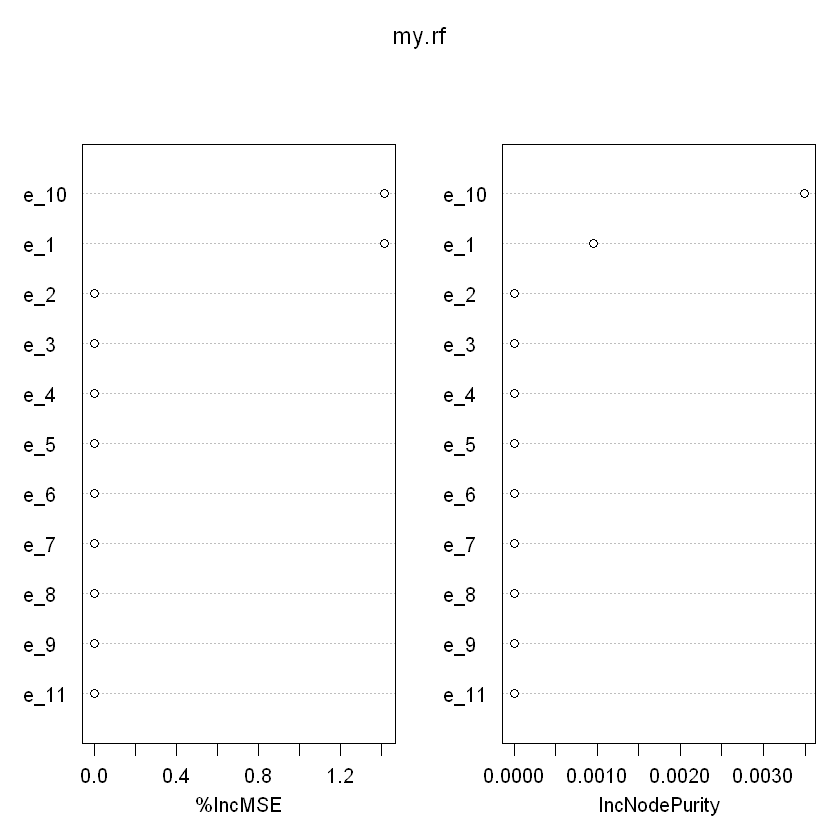

In [109]:
#Run Random Forest algorithm and print the results.

my.rf = eval(merged_episodes,test_episodes_list,seed,TRUE)

#plot saving as image
# for(s in (0:6)){
#   my.rf = eval(merged_episodes,test_episodes_list,seed,FALSE)
#   seed = seed + 1
# }

# for(ep in 1:length(test_episodes_list)){
#   jpeg(paste(ep,'_rplot.jpg'))
#   plot(test_episodes_list,ep,my.rf)
#   dev.off()
# }

# Export Sequential pattern mining(SPM)

### Function for creating output for Hirate Yamana

In [ ]:
export_ds_for_spm <- function(target_event,episodes_list,output){
  if (file.exists(output)) {
    file.remove(output)
  }
  #output for HirateYamana
  for(ep_index in (1:length(episodes_list))){
    ep = episodes_list[[ep_index]][ , !(names(episodes_list[[ep_index]]) %in% c("Timestamps"))]
    ep_list = list()
    for(i in (1:nrow(ep))){
      matches = which(ep[i,] %in% c(1))
      if(length(matches) == 0){
        next
      }
      line=paste(matches,collapse=" ")
      ep_list[i] = line
    }
    if(length(ep_list) == 0){
      next
    }
    ep_list[length(ep_list)+1] = target_event
    episode = ""
    for(ep_lli in (1:length(ep_list))){
      if(length(ep_list[[ep_lli]]) > 0){
        index = paste(paste("<",ep_lli-1,sep=""),">",sep="") #I CHANGED IT FROM ep_lli to ep_lli-1
        if(episode == ""){
          episode = paste(index,ep_list[[ep_lli]],sep=" ")
        } else {
          episode = paste(episode,paste(index,ep_list[[ep_lli]],sep=" "),sep=" -1 ")
        }
      }
    }
    write(paste(episode,"-1 -2"),file=output,append=TRUE)
  }
}

### Define the necessary variables for SPM

In [ ]:
if(export_spm){
  if(!csv){
    print("~~~~~~~SEQUENTIAL PATTERN MINING~~~~~~~")
  }
    spm_train_path = gsub(".csv",paste("_spm_",id,".csv",sep=""),argv$train)
    spm_test_path = gsub(".csv",paste("_spm_",id,".csv",sep=""),argv$test)
    spm_results_path = gsub(".csv",paste("_results_",id,".csv",sep=""),argv$train)
    
    
    target_event = argv$tet

    confidence = argv$conf

    min_dist_seq = argv$minti
    max_dist_seq = argv$maxti

    min_dist_first_last = argv$minwi
    max_dist_first_last = argv$maxwi

    max_warning_interval = argv$maxwint
    min_warning_interval = argv$minwint

    java_path = argv$java
    jspmf_path = argv$spmf

    python_path = argv$python
    cep_path = argv$cep
}
    
    

### Exporting output(as .csv file) for Hirate Yamana 

In [ ]:
if(export_spm){   
    export_ds_for_spm(target_event,episodes_list,spm_train_path)
    export_ds_for_spm(target_event,test_episodes_list,spm_test_path)
}

## Run HirateYamana algorithm 

Using a jar file named **spmf.jar**(jspmf_path) the **HirateYamana** algorithm is running for the **spm_train_path**(.csv file of the training set). 

Hirate Yamana: https://www.philippe-fournier-viger.com/spmf/hirateyamana.pdf

Hirate Yamana example: https://www.philippe-fournier-viger.com/spmf/HirateYamana.php

In [ ]:
if(export_spm){    
    if (file.exists(spm_results_path)) {
      invisible(file.remove(spm_results_path))
    }

    javaOutput <- system(paste(java_path,"-jar",jspmf_path,"run HirateYamana",spm_train_path,spm_results_path,confidence,min_dist_seq,max_dist_seq,min_dist_first_last,max_dist_first_last), intern = TRUE)

    print("The .csv file of the HirateYamanas' results looks like:")
    hiryamres <- read.csv(file = spm_results_path,header=FALSE)
    head(hiryamres)
 
}    

## Extract the Rules and make predictions for the test set.

In [ ]:
if(export_spm){    
    pythonOutput <- system(paste(python_path,cep_path,spm_results_path,spm_test_path,target_event), intern = TRUE)

    print("The python output is:")
    print(pythonOutput)

}    

## Evaluate spm results

Calculating recall, precion and F1 score for the predictions.

In [ ]:
if(export_spm){    
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    total_failures = 0

    day = 0

    warnings = list()

    ep_count=1

    #for every line of pythonOutput
    for(w in pythonOutput){ 
      #if string "Warning" appears in the line  
      if(grepl("Warning ",w,fixed=TRUE)){
        day = as.integer(str_extract(w, "\\-*\\d+\\.*\\d*")) #day's serial number  
        warnings = c(warnings,day) #
        #print("Waring list is:")
        #print(warnings)  
      #if string "Failure" appears in the line     
      } else if(grepl("Failure",w,fixed=TRUE)){  

        print("-------------------")  
        print("For episode:")
        print(ep_count) 
        #print("-------------------")
        ep_count=ep_count+1  

        day = as.integer(str_extract(w, "\\-*\\d+\\.*\\d*")) #day's serial number 

        total_failures = total_failures + 1 #increase total failures by 1

        day=day-1

        print("The serial number of the day, when the failure(target event) happens is:")
        print(day)  #day or day-1?
        #print("-------------------")


        #if there is no warning  
        if(length(warnings) == 0){
          false_negatives = false_negatives + 1 #increase false negatives by 1
        #if there is warning(s)    
        } else {
          if(length(warnings[warnings < day-max_warning_interval]) > 0){
            #increase false positives by the number of these warnings
            false_positives = false_positives + length(warnings[warnings < day-max_warning_interval]) 
          }

          #if there is warnings after the max and before the min interval from the failure(target event)   
          if(length(warnings[warnings >= (day-max_warning_interval)]) > 0 & length(warnings[warnings <= (day-min_warning_interval)]) > 0){
            true_positives = true_positives + 1 #increase true positives by 1
          #if there is no correct warning    
          } else {
            false_negatives = false_negatives + 1 #increase false negatives by 1
          }
        }
        warnings = list() #empty the list
      }
    }

    precision = true_positives/(true_positives+false_positives) #calculate the precision of the model
    if((true_positives+false_positives) == 0){
      precision = 0
    }

    recall = true_positives/total_failures #calculate recall of the model

    F1 = 2*((precision*recall)/(precision+recall)) #calculate F1 score of the model
    if(is.na((precision+recall)<=0.00)){
      F1 = 0
    }

    #prints
    #if(!csv){
    print("------------------------------------------------------------")
    if(TRUE){    
      cat(paste("dataset:",argv$test,"\ntrue_positives:", true_positives,"\nfalse_positives:", false_positives,"\nfalse_negatives:", false_negatives,"\nprecision:", precision,"\nrecall:", recall,"\nF1:", F1, "\n"))
    } else {
      cat(paste(argv$test,",", true_positives,",", false_positives,",", false_negatives,",", precision,",", recall,",", F1,",",argv$conf,",",argv$minti,",",argv$maxti,",",argv$minwi,",",argv$maxwi,",",argv$minwint,",",argv$maxwint, "\n",sep=""))
    }
    
}    